In [1]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [2]:
import os

import aquamonitor as am
import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import teotil3 as teo

# Task 2.7: Improve workflow for non-agricultural diffuse inputs

## Part A: The 2019 "1000 Lakes" dataset

From the proposal text:

> **Oppgave 2.7: Forbedre arbeidsflyten for ikke-jordbruk diffuse kilder**
> 
> NIVAs eksisterende database over punktutslipp vil bli kombinert med 2019 «1000 Innsjøer» datasettet (Hindar et al., 2020) for å identifisere overvannssjøer med liten eller ingen direkte menneskeskapt tilførsel. Dette datasettet vil bli ytterligere delt inn i to grupper (skog og fjell) basert på dominerende arealdekke, stort sett etter den opprinnelige TEOTIL arbeidsflyten. Romlig interpolering av disse datasettene (potensielt ved bruk av NDVI som en kovariat) vil gi oppdaterte konsentrasjonsbaserte eksportkoeffisienter for DIN, TON, TDP, TPP og TOC fra naturlig land.
> 
> For SS, vil initialtapskoeffisienter for naturområder hentes fra Bogen (1996). Om mulig, vil det genereres romlige og tidsvariable estimater ved bruk av regresjonsligninger utledet fra NVEs overvåkingsnettverk for sediment-transport.
> 
> Tapskoeffisienter fra byområder for alle parametere vil bli modifisert for å bruke den konsentrasjonsbaserte tilnærmingen til Åstebøl et al. (2012), i stedet for de arealbaserte koeffisientene som er i bruk.
> 
> For innsjøer vil atmosfærisk avsetning av N beregnes for hvert reginefelt ved bruk av de siste 5-årsmidler produsert av NILU. Deponering av P vil enten bli fastsatt til 15 kg/km2/år (basert på data fra Birkenes og Møsvatn), eller antatt å være null. Deponering av TOC og SS antas å være ubetydelig.

This notebook will focus on the first part of Task 2.7: preparing the 2019 "1000 Lakes" dataset for estimating background coefficients for natural land.

In the original model, background coefficients for "skog" and "fjell" were estimated by spatially interpolating concentrations of total N and P measured in ~1500 lakes across Norway in 1995. An overview of the method is provided in [Section 3.3.3 of the forprosjekt report](https://niva.brage.unit.no/niva-xmlui/bitstream/handle/11250/2985726/7726-2022%2bhigh.pdf?sequence=1&isAllowed=y#page=26). For this approach, "natural" lakes were defined as:

 * Lakes in small headwater catchments (<50 km2 catchment area)
 * Lakes with no other significant lakes (>2 km2) in the catchment upstream
 * Lake catchments with no significant urban or agricultural land use
 * Lake catchments with no significant point discharges of nutrients (e.g. from industry or sewage treatment)
 
During 2019, NIVA undertook an [updated lake survey](https://niva.brage.unit.no/niva-xmlui/handle/11250/2731702), comprising 1000 lakes across Norway. This dataset provides a basis for updating and refining the original model coefficients for "skog" and "fjell". 

## 1. Get Water chemistry data for "1000 Lakes" in 2019

In [3]:
# Login to AM
token = am.login()

Please enter your credentials.


Username:  ···
Password:  ···············


In [4]:
# Find the project code for the 2019 '1000 Lakes' survey
proj_df = am.get_projects(token=token)
proj_df.query("project_name.str.contains('Nasjonal')", engine="python")

,project_id,project_code,project_name,description
1198,12433,190091,Nasjonal Innsjøundersøkelse 2019,1000-sjøer undersøkelse gjennomført i 2019


In [5]:
# Get water chem during 2019
proj_id = 12433
st_dt = "01.01.2019"
end_dt = "31.12.2019"

stn_df = am.get_project_stations(proj_id, token=token, return_coords=True)
wc_df = am.get_project_chemistry(proj_id, st_dt, end_dt, token=token)
wc_df.head()

,project_id,project_name,station_id,station_code,station_name,sample_date,depth1,depth2,parameter_name,flag,value,unit
0,12433,Nasjonal Innsjøundersøkelse 2019,26070,221-1-2,Langtjern,2019-10-25 00:00:00+00:00,0.0,0.0,Al,NaN,280.000,µg/l
1,12433,Nasjonal Innsjøundersøkelse 2019,26070,221-1-2,Langtjern,2019-10-25 00:00:00+00:00,0.0,0.0,Al/IL,NaN,130.000,µg/l
2,12433,Nasjonal Innsjøundersøkelse 2019,26070,221-1-2,Langtjern,2019-10-25 00:00:00+00:00,0.0,0.0,Al/L,NaN,20.000,µg/l
3,12433,Nasjonal Innsjøundersøkelse 2019,26070,221-1-2,Langtjern,2019-10-25 00:00:00+00:00,0.0,0.0,Al/R,NaN,150.000,µg/l
4,12433,Nasjonal Innsjøundersøkelse 2019,26070,221-1-2,Langtjern,2019-10-25 00:00:00+00:00,0.0,0.0,Alk_4.5,NaN,0.054,mmol/l


In [6]:
# Get pars of interest
par_list = ["NH4-N", "NO3+NO2-N", "NO3-N", "TOTN", "PO4-P", "TOTP", "TOC"]
wc_df = wc_df.query("parameter_name in @par_list")

# Only surface samples
wc_df = wc_df.query("(depth1 == 0) and (depth2 == 0)")

# Tidy and average duplicates
wc_df["par_unit"] = wc_df["parameter_name"] + "_" + wc_df["unit"]
wc_df.drop(
    [
        "project_id",
        "project_name",
        "depth1",
        "depth2",
        "parameter_name",
        "unit",
        "flag",
    ],
    axis="columns",
    inplace=True,
)
id_cols = ["station_id", "station_code", "station_name", "sample_date", "par_unit"]
wc_df = wc_df.groupby(id_cols).mean()
wc_df = wc_df.unstack("par_unit")
wc_df.columns = wc_df.columns.get_level_values(1)
wc_df.reset_index(inplace=True)

# Most samples report NO3+NO2, but some just have NO3. Use NO3+NO2
# where possible and patch with NO3
wc_df["NO3+NO2-N_µg/l"] = wc_df["NO3+NO2-N_µg/l"].combine_first(wc_df["NO3-N_µg/l"])

# Calculate pars of interest
wc_df["DIN_µg/l"] = wc_df["NO3+NO2-N_µg/l"] + wc_df["NH4-N_µg/l"]
wc_df["TON_µg/l"] = wc_df["TOTN_µg/l"] - wc_df["DIN_µg/l"]
wc_df["TDP_µg/l"] = wc_df["PO4-P_µg/l"]
wc_df["TPP_µg/l"] = wc_df["TOTP_µg/l"] - wc_df["TDP_µg/l"]

pars = [
    "DIN_µg/l",
    "TON_µg/l",
    "TOTN_µg/l",
    "TDP_µg/l",
    "TPP_µg/l",
    "TOTP_µg/l",
    "TOC_mg/l",
]
cols = id_cols[:-1] + pars
wc_df = wc_df[cols]

assert pd.isna(wc_df).sum().sum() == 0

# Some lakes have multiple samples. Average
id_cols = ["station_id", "station_code", "station_name"]
wc_df = wc_df.groupby(id_cols).mean().reset_index()

print(len(wc_df), "lakes sampled in project.")

wc_df.head()

1001 lakes sampled in project.


par_unit,station_id,station_code,station_name,DIN_µg/l,TON_µg/l,TOTN_µg/l,TDP_µg/l,TPP_µg/l,TOTP_µg/l,TOC_mg/l
0,26070,221-1-2,Langtjern,22.0,348.0,370.0,1.0,10.0,11.0,20.0
1,26071,101-2-7,Hokksjøen,60.0,520.0,580.0,1.0,9.0,10.0,24.2
2,26072,402-2-13,Sætertjern,43.0,357.0,400.0,1.0,8.0,9.0,20.3
3,26073,419-1-25,Mjøgsjøen,29.0,381.0,410.0,1.0,9.0,10.0,25.8
4,26074,425-2-2,Kottern,52.0,318.0,370.0,1.0,10.0,11.0,16.8


## 2. Get catchment boundaries

Jose previously derived catchment boundaries for the 1000 Lakes and these are available in the Hub's database.

In [7]:
# Find project in Hub's database
eng = nivapy.da.connect_postgis()
nivapy.da.select_jhub_projects(eng)

Connection successful.


,project_id,project_code,project_name,aquamonitor_id,contact,description
0,1,Refelv_Over,Overvåking av referanseelver,11226.0,None,Overvåking av referanseelver
1,2,190246,CL Vestland,NaN,KAU,Critical loads calculations for Vestland
2,4,O-190091,Nasjonal Innsjøundersøkelse 2019,12433.0,HIN,1000 Lakes survey in 2019


In [8]:
# Get outflows and catchments. We want project_id = 4
stn_gdf, cat_gdf = nivapy.da.select_jhub_project_catchments([4], eng)
assert len(stn_gdf) == len(cat_gdf)
stn_gdf = stn_gdf.to_crs("epsg:25833")
cat_gdf = cat_gdf.to_crs("epsg:25833")
print(len(cat_gdf), "catchment polygons.")
del cat_gdf["station_id"]

# Join to water chem
cat_gdf = cat_gdf.merge(
    wc_df[["station_id"] + pars],
    left_on="aquamonitor_id",
    right_on="station_id",
    how="left",
)
cat_gdf["station_id"] = cat_gdf["aquamonitor_id"]
del cat_gdf["aquamonitor_id"]

cat_gdf.dropna(how="any", inplace=True)
print(len(cat_gdf), "catchments with complete chemistry data.")

cat_gdf.head()

1001 catchment polygons.
999 catchments with complete chemistry data.


,station_code,station_name,longitude,latitude,geom,station_id,DIN_µg/l,TON_µg/l,TOTN_µg/l,TDP_µg/l,TPP_µg/l,TOTP_µg/l,TOC_mg/l
0,221-1-2,Langtjern,11.850610,59.809915,"MULTIPOLYGON (((323585.000 6634905.000, 323605...",26070,22.0,348.0,370.0,1.0,10.0,11.0,20.0
1,101-2-7,Hokksjøen,11.559946,59.005125,"MULTIPOLYGON (((304405.000 6546445.000, 304415...",26071,60.0,520.0,580.0,1.0,9.0,10.0,24.2
2,402-2-13,Sætertjern,12.443670,60.057771,"MULTIPOLYGON (((357405.000 6662305.000, 357445...",26072,43.0,357.0,400.0,1.0,8.0,9.0,20.3
3,419-1-25,Mjøgsjøen,11.845276,60.332035,"MULTIPOLYGON (((325515.000 6692835.000, 325575...",26073,29.0,381.0,410.0,1.0,9.0,10.0,25.8
4,425-2-2,Kottern,12.511994,60.587319,"MULTIPOLYGON (((363705.000 6720805.000, 363765...",26074,52.0,318.0,370.0,1.0,10.0,11.0,16.8


## 3. Filter catchments

The original TEOTIL model only considered lakes with the following criteria:

 * Total upstream area <50 km2
 * No upstream lakes >2 km2
 * No significant human inputs (i.e. no urban, agricultural or point sources)
 
The code below repeats this analysis using the same parameters for now. However, these can be adjusted later, if desired.

In [9]:
# Set criteria to define "near-pristine" or "natural" lakes
upstr_area_thresh = 50  # km2
upstr_lake_thresh = 2  # km2
anthrop_pct_thresh = 1  # Maximum percentage of catchment area that is (urban + agri)

### 3.1. Threshold based on catchment area

In [10]:
print(len(cat_gdf), "catchments with complete data.")

# Filter catchments based on upstream area
cat_gdf["area_km2"] = cat_gdf.to_crs({"proj": "cea"}).geometry.area / 1e6
cat_gdf = cat_gdf.query("area_km2 < @upstr_area_thresh")
print(f"{len(cat_gdf)} catchments with an upstream area < {upstr_area_thresh} km2.")

999 catchments with complete data.
900 catchments with an upstream area < 50 km2.


### 3.2. Threshold based on upstream lakes

In [11]:
# Read NVE lakes database
data_year = 2022
data_fold = f"/home/jovyan/shared/teotil3/core_data_june_{data_year}"
nve_gdb = os.path.join(data_fold, "hydrology", "NVEData.gdb")
lake_gdf = gpd.read_file(nve_gdb, driver="fileGDB", layer="Innsjo").to_crs("epsg:25833")
cols = [
    "vatnLnr",
    "geometry",
]
lake_gdf = lake_gdf[cols]

# Recalculate 'area_km2' column as original contains some odd values
lake_gdf["area_km2"] = lake_gdf.to_crs({"proj": "cea"}).geometry.area / 1e6

# Filter based on lake threshold
lake_gdf = lake_gdf.query("area_km2 > @upstr_lake_thresh")
del lake_gdf["area_km2"]

print(
    f"{len(lake_gdf)} lakes in NVE's database with an area greater than {upstr_lake_thresh} km2."
)

# Remove the lakes that were sampled in 2019 from NVE's dataset
# as these lakes will be included in the catchments, but we don't
# want to exclude catchments based on lakes that were actually
# sampled. NOTE: 'stn_df' has the sampling locations from AM;
# 'stn_gdf' has the outflow locations used by Jose
sampled_lakes = (
    nivapy.spatial.identify_point_in_polygon(
        stn_df,
        lake_gdf,
        pt_col="station_id",
        poly_col="vatnLnr",
        lat_col="latitude",
        lon_col="longitude",
    )
    .dropna(subset="vatnLnr")["vatnLnr"]
    .tolist()
)
lake_gdf = lake_gdf.query("vatnLnr not in @sampled_lakes")

print(
    f"Of these, {len(sampled_lakes)} were sampled in 2019. This leaves {len(lake_gdf)} "
    f"lakes in NVE's database with an area greater than {upstr_lake_thresh} "
    "km2 and that are potentially 'upstream' of sampled lakes."
)

# Identify upstream lakes
upstr_lake_gdf = lake_gdf.sjoin(cat_gdf, how="inner", predicate="within").reset_index(
    drop=True
)[["vatnLnr", "geometry", "station_id", "station_code", "station_name"]]
print(
    f"{len(upstr_lake_gdf)} of the sampled catchments contain upstream lakes with an area greater than {upstr_lake_thresh} km2."
)
upstr_lake_gdf

1044 lakes in NVE's database with an area greater than 2 km2.


/opt/conda/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3361: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


Of these, 99 were sampled in 2019. This leaves 945 lakes in NVE's database with an area greater than 2 km2 and that are potentially 'upstream' of sampled lakes.
7 of the sampled catchments contain upstream lakes with an area greater than 2 km2.


,vatnLnr,geometry,station_id,station_code,station_name
0,2456,"MULTIPOLYGON (((1047696.010 7749803.280, 10476...",27009,2030-2-35,Lynnevatn
1,878,"MULTIPOLYGON (((256968.040 7012392.960, 256973...",26781,1653-3-10,Benna
2,1261,"MULTIPOLYGON (((166273.930 6531737.530, 166300...",26355,815-3-8,Leivatnet
3,1846,"MULTIPOLYGON (((48014.920 6622970.620, 48014.6...",26572,1134-2-8,Leirdålsvatna
4,2055,"MULTIPOLYGON (((-8631.820 6721089.220, -8622.3...",26637,1241-2-41,Skjelbreidvatnet
5,258,"MULTIPOLYGON (((265440.720 6795251.490, 265432...",26226,501-3-9,Mellsjøen
6,838,"MULTIPOLYGON (((493512.950 7484753.310, 493532...",26835,1804-3-17,Sørvatnet


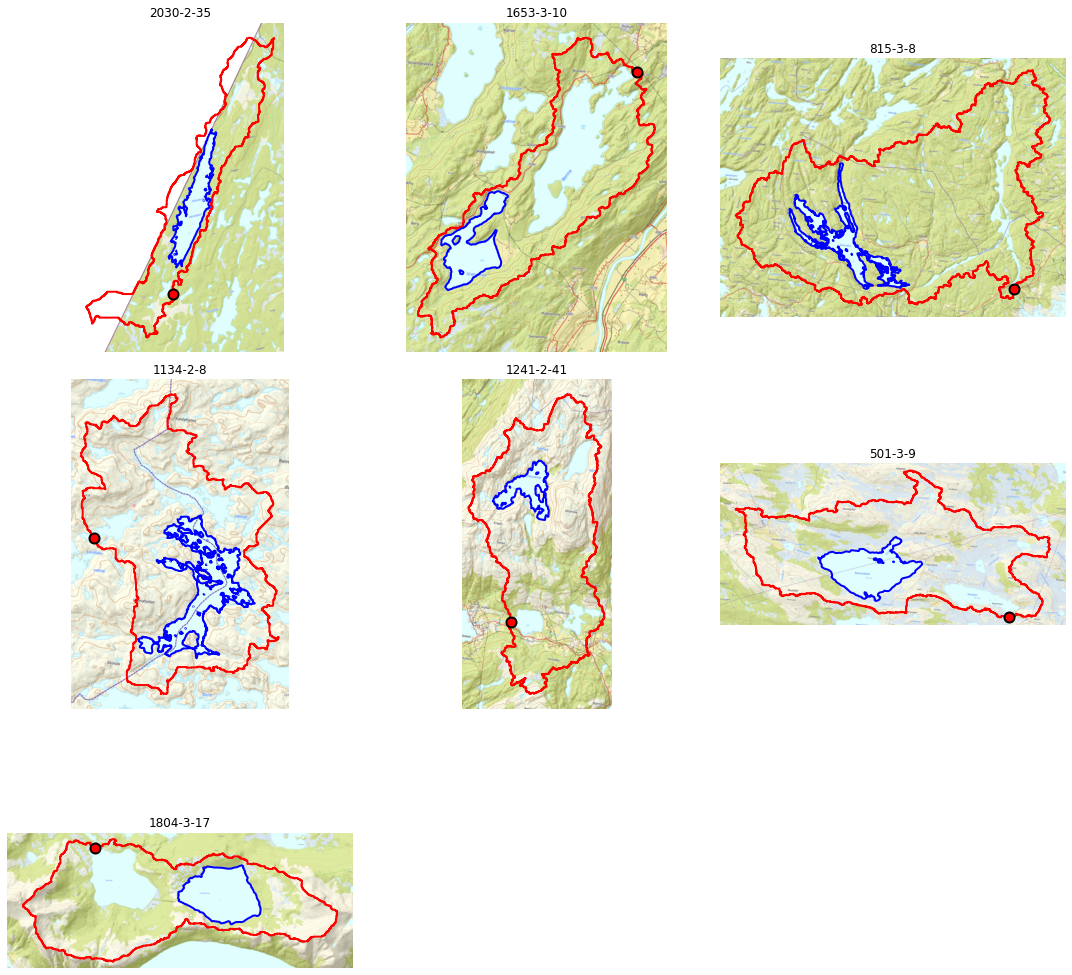

In [12]:
# Plot catchments with lakes upstream
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
axes = axes.flatten()
fig.delaxes(axes[-1])
fig.delaxes(axes[-2])

for idx, row in upstr_lake_gdf.iterrows():
    stn_id = row["station_id"]
    stn_code = row["station_code"]
    cat_poly = cat_gdf.query("station_id == @stn_id")
    stn_pt = stn_gdf.query("aquamonitor_id == @stn_id")

    cat_poly.plot(ax=axes[idx], facecolor="none", edgecolor="red", linewidth=2)
    stn_pt.plot(
        ax=axes[idx], facecolor="red", edgecolor="black", linewidth=2, markersize=100
    )
    upstr_lake_gdf.iloc[[idx]].plot(
        ax=axes[idx], facecolor="none", edgecolor="blue", linewidth=2
    )
    cx.add_basemap(
        axes[idx],
        crs=cat_poly.crs.to_string(),
        attribution=False,
        source="https://cache.kartverket.no/topo4/v1/gmaps/{z}/{x}/{y}.png",
    )
    axes[idx].set_axis_off()
    axes[idx].set_title(stn_code)
plt.tight_layout()

On the maps above, red outlines show the catchment boundaries derived by Jose and red circles mark the outflows of sampled lakes. Dark blue outlines identify lakes with a surface area greater than `upstr_lake_thresh` km2 that are upstream of sampled lakes. All these catchments are therefore excluded from further analysis.

In [13]:
# Remove catchments with upstream lakes from 'cat_gdf'
cats_with_lakes_upstream = upstr_lake_gdf["station_id"].tolist()
cat_gdf = cat_gdf.query("station_id not in @cats_with_lakes_upstream")
print(
    f"{len(cat_gdf)} catchments with an upstream area < {upstr_area_thresh} "
    f"km2 and no upstream lakes > {upstr_lake_thresh} km2."
)

893 catchments with an upstream area < 50 km2 and no upstream lakes > 2 km2.


### 3.3. Threshold based on urban and agricultural proportions

In [14]:
# Read AR50
ar50_gdb = os.path.join(data_fold, "land_cover", "nibio_ar50.gdb")
ar50_gdf = gpd.read_file(ar50_gdb, driver="fileGDB", layer="org_ar_ar50_flate")

print("Reclassifying...")
land_class_csv = r"https://raw.githubusercontent.com/NIVANorge/teotil3/main/data/ar50_artype_classes.csv"
artype_df = pd.read_csv(land_class_csv)
ar50_gdf = pd.merge(ar50_gdf, artype_df, how="left", on="artype")
ar50_gdf = ar50_gdf[["teotil", "geometry"]]

print("Reprojecting to equal area...")
cat_gdf_cea = cat_gdf.to_crs({"proj": "cea"})
ar50_gdf_cea = ar50_gdf.to_crs({"proj": "cea"})

print("Intersecting polygons...")
int_gdf = gpd.overlay(
    cat_gdf_cea, ar50_gdf_cea, how="intersection", keep_geom_type=True
)
int_gdf["area_km2"] = int_gdf["geometry"].area / 1e6

print("Aggregating...")
lc_df = int_gdf.groupby(["station_id", "teotil"]).sum()["area_km2"]
lc_df = lc_df.unstack("teotil")
lc_df.columns = [f"a_{i}_km2" for i in lc_df.columns]
lc_df.reset_index(inplace=True)
lc_df.columns.name = ""

cat_gdf = pd.merge(cat_gdf, lc_df, on="station_id", how="left")
cols = [
    "a_agri_km2",
    "a_glacier_km2",
    "a_lake_km2",
    "a_sea_km2",
    "a_upland_km2",
    "a_urban_km2",
    "a_wood_km2",
]
for col in cols:
    if col in cat_gdf.columns:
        cat_gdf[col].fillna(0, inplace=True)

# Get pct (urban + agri)
cat_gdf["a_anthrop_km2"] = cat_gdf["a_agri_km2"] + cat_gdf["a_urban_km2"]
cat_gdf["a_anthrop_pct"] = 100 * cat_gdf["a_anthrop_km2"] / cat_gdf["area_km2"]
del cat_gdf["a_other_km2"]

# Get just catchments where diffuse anthropogenic influence is low
n_anthrop = len(cat_gdf.query("a_anthrop_pct >= @anthrop_pct_thresh"))
cat_gdf = cat_gdf.query("a_anthrop_pct < @anthrop_pct_thresh")

print(
    f"\n{n_anthrop} catchments have a combined (urban + agricultural) land cover of >= {anthrop_pct_thresh} %.\n"
    f"These will be removed from the dataset. {len(cat_gdf)} catchments remain."
)

Reclassifying...
Reprojecting to equal area...
Intersecting polygons...
Aggregating...

108 catchments have a combined (urban + agricultural) land cover of >= 1 %.
These will be removed from the dataset. 785 catchments remain.


### 3.4. Check for point discharges

Each year, as part of Elveovervåkingsprogrammet, MDir provides NIVA with information regarding the location and magnitude of point discharges from industrial and sewage treatment plants. The following SQL has been used to extract locations for all discharges of TOTP, TOTN, TOC and SS since 2010.  

    SELECT
        b.anlegg_nr,
        AVG(b.lon_utl)          AS lon,
        AVG(b.lat_utl)          AS lat,
        c.name,
        SUM(a.value * d.factor) AS value_tonnes
    FROM
        resa2.rid_punktkilder_inpar_values a,
        resa2.rid_punktkilder              b,
        resa2.rid_punktkilder_outpar_def   c,
        resa2.rid_punktkilder_inp_outp     d
    WHERE
        a.anlegg_nr = b.anlegg_nr
        AND a.inp_par_id = d.in_pid
        AND c.out_pid = d.out_pid
        AND year > 2010
        AND name IN ( 'Tot-P', 'Tot-N', 'TOC', 'S.P.M.' )
        AND b.lon_utl IS NOT NULL
        AND b.lat_utl IS NOT NULL
    GROUP BY
        b.anlegg_nr,
        c.name
    ORDER BY
        anlegg_nr;
        
This file is saved as a CSV and processed below.

In [15]:
# Read point discharges since 2010
pt_df = pd.read_csv("../../data/point_discharges_since_2010.csv", sep=";", decimal=",")
pt_df.set_index(["ANLEGG_NR", "LON", "LAT", "NAME"], inplace=True)
pt_df = pt_df.unstack("NAME")
pt_df.columns = pt_df.columns.get_level_values(1)
pt_df.reset_index(inplace=True)
pt_df.rename(
    {
        "ANLEGG_NR": "anlegg_nr",
        "LON": "longitude",
        "LAT": "latitude",
        "S.P.M.": "SS",
        "Tot-P": "TOTP",
        "Tot-N": "TOTN",
    },
    axis="columns",
    inplace=True,
)

# Identify any point discharges within catchments of interest
cats_with_pt = nivapy.spatial.identify_point_in_polygon(
    pt_df,
    cat_gdf,
    pt_col="anlegg_nr",
    poly_col="station_id",
    lat_col="latitude",
    lon_col="longitude",
).dropna(subset="station_id")

if len(cats_with_pt) > 0:
    cat_ids_to_drop = cats_with_pt["station_id"].unique().tolist()
    cat_gdf = cat_gdf.query("station_id not in @cat_ids_to_drop")

print(
    f"\n{len(cats_with_pt)} catchments contain point inputs.\n"
    f"These will be removed from the dataset. {len(cat_gdf)} catchments remain."
)

/opt/conda/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)



0 catchments contain point inputs.
These will be removed from the dataset. 785 catchments remain.


/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3361: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [16]:
# Tidy catchments
cols = (
    [
        "station_id",
        "station_code",
        "station_name",
        "longitude",
        "latitude",
        "area_km2",
        "a_agri_km2",
        "a_glacier_km2",
        "a_lake_km2",
        "a_upland_km2",
        "a_urban_km2",
        "a_wood_km2",
    ]
    + pars
    + ["geom"]
)
cat_gdf = cat_gdf[cols].copy()
cat_gdf.rename_geometry("geometry", inplace=True)

# Filter outflow points to match
valid_cat_ids = cat_gdf["station_id"].unique().tolist()
stn_gdf = stn_gdf.query("aquamonitor_id in @valid_cat_ids")
assert len(stn_gdf) == len(cat_gdf)

display(stn_gdf.head())
display(cat_gdf.head())

,station_id,station_code,station_name,aquamonitor_id,longitude,latitude,geom
0,259,221-1-2,Langtjern,26070,11.850610,59.809915,POINT (323371.564 6634439.721)
1,260,101-2-7,Hokksjøen,26071,11.559946,59.005125,POINT (302446.090 6545708.790)
2,261,402-2-13,Sætertjern,26072,12.443670,60.057771,POINT (357686.180 6660596.800)
3,262,419-1-25,Mjøgsjøen,26073,11.845276,60.332035,POINT (325847.930 6692557.560)
4,263,425-2-2,Kottern,26074,12.511994,60.587319,POINT (363714.050 6719400.670)


,station_id,station_code,station_name,longitude,latitude,area_km2,a_agri_km2,a_glacier_km2,a_lake_km2,a_upland_km2,a_urban_km2,a_wood_km2,DIN_µg/l,TON_µg/l,TOTN_µg/l,TDP_µg/l,TPP_µg/l,TOTP_µg/l,TOC_mg/l,geometry
0,26070,221-1-2,Langtjern,11.850610,59.809915,0.426415,0.00000,0.0,0.051958,0.116018,0.0,0.258439,22.0,348.0,370.0,1.0,10.0,11.0,20.0,"MULTIPOLYGON (((323585.000 6634905.000, 323605..."
1,26071,101-2-7,Hokksjøen,11.559946,59.005125,5.500691,0.03569,0.0,0.354653,0.570944,0.0,4.539403,60.0,520.0,580.0,1.0,9.0,10.0,24.2,"MULTIPOLYGON (((304405.000 6546445.000, 304415..."
2,26072,402-2-13,Sætertjern,12.443670,60.057771,1.572078,0.00000,0.0,0.187471,0.228336,0.0,1.154075,43.0,357.0,400.0,1.0,8.0,9.0,20.3,"MULTIPOLYGON (((357405.000 6662305.000, 357445..."
3,26073,419-1-25,Mjøgsjøen,11.845276,60.332035,1.018257,0.00000,0.0,0.050268,0.353306,0.0,0.614682,29.0,381.0,410.0,1.0,9.0,10.0,25.8,"MULTIPOLYGON (((325515.000 6692835.000, 325575..."
4,26074,425-2-2,Kottern,12.511994,60.587319,2.126635,0.00000,0.0,0.155520,0.262435,0.0,1.661206,52.0,318.0,370.0,1.0,10.0,11.0,16.8,"MULTIPOLYGON (((363705.000 6720805.000, 363765..."


In [17]:
# Save
teo_gpkg = os.path.join(data_fold, "tidied", "teotil3_data.gpkg")
teo.io.geodataframe_to_geopackage(
    stn_gdf,
    teo_gpkg,
    "1000_lakes_natural_outflows",
)
teo.io.geodataframe_to_geopackage(
    cat_gdf,
    teo_gpkg,
    "1000_lakes_natural_catchments",
)

### 3.5. Summary

This notebook has compiled a water chemistry dataset of 785 "natural" lakes, together with catchment properties. The definition of "natural" matches that used in the original model, but the water chemistry data is updated based on national lake survey data collected by NIVA in 2019.

 * Out of 999 catchments in the "1000 Lakes" project with complete data, 900 have a catchment area less than 50 km2
 * Of these, a further 7 catchments have lakes upstream of the sampled lake with a surface area ≥2 km2. This leaves 893 catchments
 * Of these, 108 have a combined (urban + agricultural) land cover percentage ≥1%. This leaves 785 catchments 
 * None of these 785 catchments have any point inputs of N, P, C or SS recorded in NIVA's database since 2010
 * **The final "natural" water chemistry dataset therefore comprises 785 sites and catchments**